In [1]:
import os

import torch
import torch.nn as nn

from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output

import warnings
warnings.simplefilter('ignore')

In [2]:
class MonetPhotoDataset(Dataset):
    def __init__(self, root_monet, root_photo, transform=None):
        self.transform = transform
        self.root_monet = root_monet
        self.root_photo = root_photo
        
        self.monet_images = os.listdir(root_monet)
        self.photo_images = os.listdir(root_photo)
        self.length_dataset = min(len(self.monet_images), len(self.photo_images))

        self.monet_len = len(self.monet_images)
        self.photo_len = len(self.photo_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, idx):
        monet_img = self.monet_images[idx % self.monet_len]
        photo_img = self.photo_images[idx % self.photo_len]
        
        monet_path = os.path.join(self.root_monet, monet_img)
        photo_path = os.path.join(self.root_photo, photo_img)
        
        monet_img = Image.open(monet_path).convert('RGB')
        photo_img = Image.open(photo_path).convert('RGB')
    
        
        monet_img = self.transform(monet_img)
        photo_img = self.transform(photo_img)
        
        return monet_img, photo_img

In [3]:
IMAGE_SIZE = 256

In [4]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
}

In [5]:
dataset = MonetPhotoDataset('monet_jpg/', 'photo_jpg/', transform['test'])
len(dataset)

300

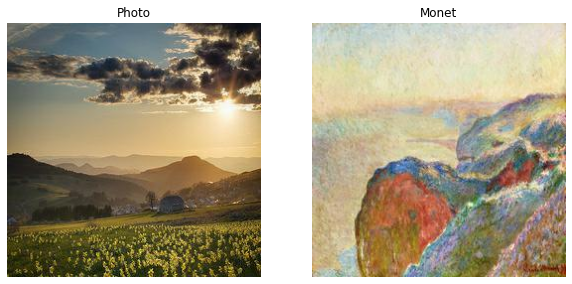

In [6]:
m, p = next(iter(dataset))

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.axis('off')
plt.title('Photo')
plt.imshow(p.permute(1, 2, 0) * 0.5 + 0.5)


plt.subplot(122)
plt.axis('off')
plt.title('Monet')
plt.imshow(m.permute(1, 2, 0) * 0.5 + 0.5)
plt.show()

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, dropout=True):
        super(Upsample, self).__init__()
        self.dropout = dropout
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=nn.InstanceNorm2d),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.dropout_layer = nn.Dropout2d(0.5)

    def forward(self, x, shortcut=None):
        x = self.block(x)
        if self.dropout:
            x = self.dropout_layer(x)

        if shortcut is not None:
            x = torch.cat([x, shortcut], dim=1)

        return x


class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, apply_instancenorm=True):
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=nn.InstanceNorm2d)
        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.apply_norm = apply_instancenorm

    def forward(self, x):
        x = self.conv(x)
        if self.apply_norm:
            x = self.norm(x)
        x = self.relu(x)

        return x


class Generator(nn.Module):
    def __init__(self, filter=64):
        super(Generator, self).__init__()
        self.downsamples = nn.ModuleList([
            Downsample(3, filter, kernel_size=4, apply_instancenorm=False),
            Downsample(filter, filter * 2),
            Downsample(filter * 2, filter * 4),
            Downsample(filter * 4, filter * 8),
            Downsample(filter * 8, filter * 8),
            Downsample(filter * 8, filter * 8),
            Downsample(filter * 8, filter * 8),
        ])

        self.upsamples = nn.ModuleList([
            Upsample(filter * 8, filter * 8),
            Upsample(filter * 16, filter * 8),
            Upsample(filter * 16, filter * 8),
            Upsample(filter * 16, filter * 4, dropout=False),
            Upsample(filter * 8, filter * 2, dropout=False),
            Upsample(filter * 4, filter, dropout=False)
        ])

        self.last = nn.Sequential(
            nn.ConvTranspose2d(filter * 2, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        skips = []
        for l in self.downsamples:
            x = l(x)
            skips.append(x)

        skips = reversed(skips[:-1])
        for l, s in zip(self.upsamples, skips):
            x = l(x, s)

        out = self.last(x)

        return out


class Discriminator(nn.Module):
    def __init__(self, filter=64):
        super(Discriminator, self).__init__()

        self.block = nn.Sequential(
            Downsample(3, filter, kernel_size=4, stride=2, apply_instancenorm=False),
            Downsample(filter, filter * 2, kernel_size=4, stride=2),
            Downsample(filter * 2, filter * 4, kernel_size=4, stride=2),
            Downsample(filter * 4, filter * 8, kernel_size=4, stride=1),
        )

        self.last = nn.Conv2d(filter * 8, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x):
        x = self.block(x)
        x = self.last(x)

        return x

In [12]:
NUM_EPOCHS = 150
LAMBDA_CYCLE = 10
LAMBDA_IDENTITY = 2
LEARNING_RATE = 2e-4
BATCH_SIZE = 4

In [13]:
#disc_M = Discriminator().to(DEVICE)
#disc_P = Discriminator().to(DEVICE)
#gen_M = Generator().to(DEVICE)
#gen_P = Generator().to(DEVICE)

gen_M = torch.load('gen_M.pth')
gen_P = torch.load('gen_P.pth')
disc_M = torch.load('disc_M.pth')
disc_P = torch.load('disc_P.pth')

opt_disc = torch.optim.Adam(
    list(disc_M.parameters()) + list(disc_P.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999)
)

opt_gen = torch.optim.Adam(
    list(gen_M.parameters()) + list(gen_P.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999)
)

l1 = nn.L1Loss()
mse = nn.MSELoss()

loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Epoch: 149
------------------------------
_LOSSES_
D_P_loss:     0.301,
D_M_loss:     0.071

loss_G_P:     0.570,
loss_G_M:     1.253

cycle_loss:    1.070,
identity_loss:    0.158

------------------------------


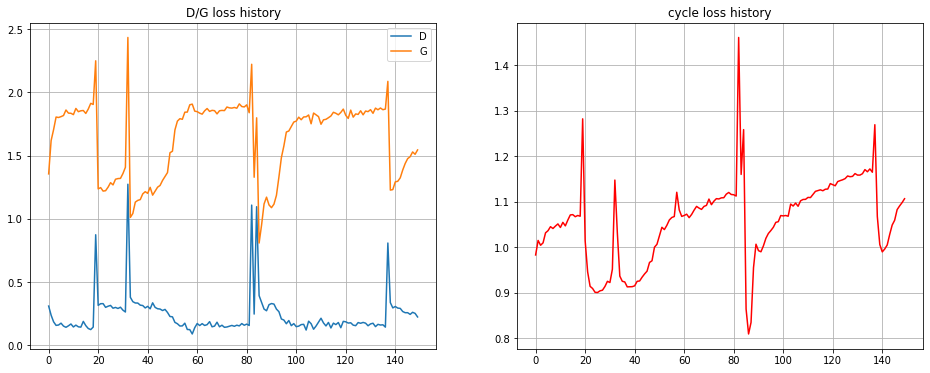

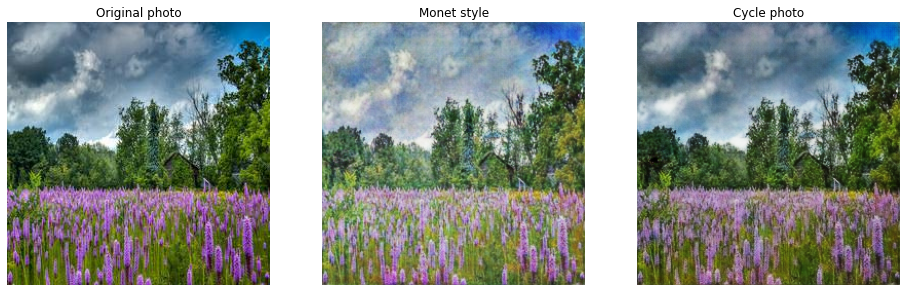

In [14]:
D_losses_epoch = []
G_losses_epoch = []
cycle_losses_epoch = []

for epoch in range(NUM_EPOCHS):
    D_losses = []
    G_losses = []
    cycle_losses = []
    
    #loop = tqdm(loader, leave=True)
    for idx, (monet, photo) in enumerate(loader):
        monet = monet.to(DEVICE)
        photo = photo.to(DEVICE)

        #Train Discriminators P and M
        fake_photo = gen_P(monet)
        D_P_real = disc_P(photo)
        D_P_fake = disc_P(fake_photo.detach())
        D_P_real_loss = mse(torch.ones(D_P_real.shape).to(DEVICE), D_P_real)
        D_P_fake_loss = mse(torch.zeros(D_P_fake.shape).to(DEVICE), D_P_fake)
        D_P_loss = D_P_real_loss + D_P_fake_loss
        
        fake_monet = gen_M(photo)
        D_M_real = disc_M(monet)
        D_M_fake = disc_M(fake_monet.detach())
        D_M_real_loss = mse(torch.ones(D_M_real.shape).to(DEVICE), D_M_real)
        D_M_fake_loss = mse(torch.zeros(D_M_fake.shape).to(DEVICE), D_M_fake)
        D_M_loss = D_M_real_loss + D_M_fake_loss

        D_loss = (D_P_loss + D_M_loss) / 2
        opt_disc.zero_grad()
        D_loss.backward()
        opt_disc.step()
        
        #Tain Generators P and M
        D_P_fake = disc_P(fake_photo)
        D_M_fake = disc_M(fake_monet)
        loss_G_P = mse(torch.ones(D_P_fake.shape).to(DEVICE), D_P_fake)
        loss_G_M = mse(torch.ones(D_M_fake.shape).to(DEVICE), D_M_fake)
        
        #Cycle loss
        cycle_photo = gen_P(fake_monet)
        cycle_monet = gen_M(fake_photo)
        cycle_photo_loss = l1(photo, cycle_photo)
        cycle_monet_loss = l1(monet, cycle_monet)
        
        #Identity loss
        identity_photo = gen_P(photo)
        identity_monet = gen_M(monet)
        identity_photo_loss = l1(photo, identity_photo)
        identity_monet_loss = l1(monet, identity_monet)
        
        #Total G loss
        G_loss = (
            loss_G_P 
            + loss_G_M
            + cycle_photo_loss * LAMBDA_CYCLE
            + cycle_monet_loss * LAMBDA_CYCLE
            + identity_photo_loss * LAMBDA_IDENTITY
            + identity_monet_loss * LAMBDA_IDENTITY
        )

        opt_gen.zero_grad()
        G_loss.backward()
        opt_gen.step() 
        
        D_losses.append(D_loss.item())
        G_losses.append((loss_G_P + loss_G_M).item())
        cycle_losses.append((cycle_photo_loss * LAMBDA_CYCLE + cycle_monet_loss * LAMBDA_CYCLE).item())
        
    #Logging
    print(f'Epoch: {epoch}')
    print('--' * 15)

    print('_LOSSES_')
    #print('Discriminator')
    print(f'D_P_loss: {D_P_loss:9.3f},\nD_M_loss: {D_M_loss:9.3f}' + '\n')

    #print('Generator')
    print(f'loss_G_P: {loss_G_P:9.3f},\nloss_G_M: {loss_G_M:9.3f}' + '\n')
    print(f'cycle_loss: {cycle_photo_loss*LAMBDA_CYCLE + cycle_monet_loss*LAMBDA_CYCLE: 8.3f},')
    print(f'identity_loss: {identity_photo_loss*LAMBDA_IDENTITY + identity_monet_loss*LAMBDA_IDENTITY: 8.3f}' + '\n')
    print('--' * 15)

    torch.save(gen_M, 'gen_M.pth')
    torch.save(gen_P, 'gen_P.pth')
    torch.save(disc_M, 'disc_M.pth')
    torch.save(disc_P, 'disc_P.pth')

    D_losses_epoch.append(np.mean(D_losses))
    G_losses_epoch.append(np.mean(G_losses))
    cycle_losses_epoch.append(np.mean(cycle_losses))
    D_losses = []
    G_losses = []
    cycle_losses = []

    plt.figure(figsize=(16, 6))

    plt.subplot(121)
    plt.plot(D_losses_epoch, label='D')
    plt.plot(G_losses_epoch, label='G')
    plt.title('D/G loss history')
    plt.grid()
    plt.legend()

    plt.subplot(122)
    plt.plot(cycle_losses_epoch, label='cycle', c='r')
    plt.title('cycle loss history')
    plt.grid()
    plt.show()

    plt.figure(figsize=(16, 6))

    plt.subplot(131)
    plt.title('Original photo')
    plt.axis('off')
    plt.imshow(photo.cpu().detach()[0].squeeze().permute(1, 2, 0) * 0.5 + 0.5)

    plt.subplot(132)
    plt.title('Monet style')
    plt.axis('off')
    plt.imshow(fake_monet.cpu().detach()[0].squeeze().permute(1, 2, 0) * 0.5 + 0.5)

    plt.subplot(133)
    plt.title('Cycle photo')
    plt.axis('off')
    plt.imshow(cycle_photo.cpu().detach()[0].squeeze().permute(1, 2, 0) * 0.5 + 0.5)

    plt.show()

    clear_output(wait=True)

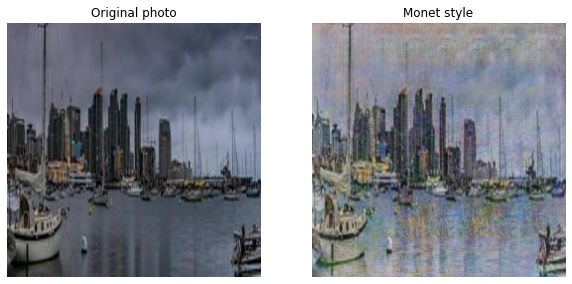

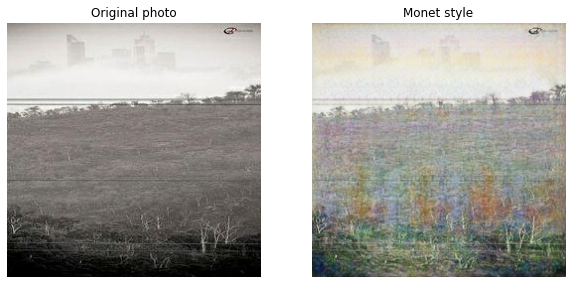

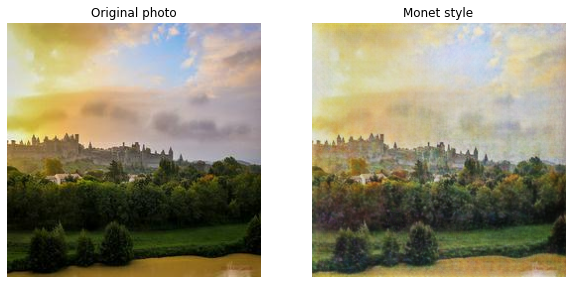

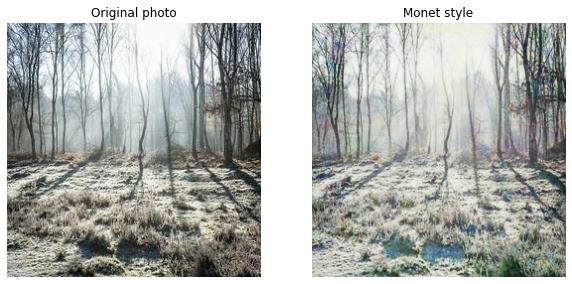

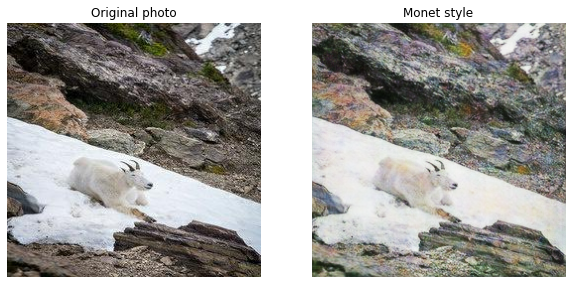

In [27]:
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
dataset = MonetPhotoDataset('monet_jpg/', 'photo_jpg/', transform['test'])

for idx, (monet, photo) in enumerate(loader):
    monet = monet.to(DEVICE)
    photo = photo.to(DEVICE)
    fake_photo = gen_P(monet)
    fake_monet = gen_M(photo)
    
    plt.figure(figsize=(10, 6))
    
    plt.subplot(121)
    plt.title('Original photo')
    plt.axis('off')
    plt.imshow(photo.cpu().detach()[0].squeeze().permute(1, 2, 0) * 0.5 + 0.5)
    
    plt.subplot(122)
    plt.title('Monet style')
    plt.axis('off')

    plt.imshow(fake_monet.cpu().detach()[0].squeeze().permute(1, 2, 0) * 0.5 + 0.5)
        
    plt.show()
        
    if idx == 4:
        break

In [28]:
torch.save(gen_M.state_dict(), 'gen_M.pth')

In [31]:
gan = Generator()
gan.load_state_dict(torch.load('gen_M.pth'))

<All keys matched successfully>